In [1]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py # Use the official tokenization script created by the Google team
!pip install keras
!pip install tensorflow-hub
!pip install tensorflow 
!pip install bert-tensorflow

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 67 kB 1.6 MB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow_hub as hub

import tokenization #https://github.com/tensorflow/models/blob/master/official/nlp/bert/tokenization.py

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
 
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

#Asi y todo puede que no sea posible tener resultados reproducibles por las librerias encargadas del aceleramiento por gpu

semilla = 1460

np.random.seed(semilla)
tf.random.set_seed(semilla)
torch.manual_seed(semilla)
torch.cuda.manual_seed_all(semilla)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

# Descargo el modelo de Bert

In [4]:
# BERT-Large uncased: 24-layer, 1024-hidden-nodes, 16-attention-heads, 340M parameters

module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)

# Se utiliza el tokenizador de la biblioteca "transformers"

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [1]:
# Outputs:
# Tokens
# Pad masks - BERT learns by masking certain tokens in each sequence.
# Segment id

def tokenize_map(tweets):
    
    input_ids = []
    attention_masks = []
    token_type_ids = []

    
    for text in tweets:
        
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 160,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construccion de attn. masks.
                            return_tensors = 'pt',     # Retorna un tensor de pytorch.
                       )

        # Add the encoded sentence to the id list. 
        
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        
        attention_masks.append(encoded_dict['attention_mask'])
        
        # No se para que sirve esto
        
        token_type_ids.append(encoded_dict['token_type_ids'])

    
    #Concateno los tensores que tenia como listas de tensores unidimensionales
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    token_type_ids = torch.cat(token_type_ids, dim=0)
    
    #Convierto los tensores a arrays
    input_ids = np.array(input_ids)
    attention_masks = np.array(attention_masks)
    token_type_ids = np.array(token_type_ids)
    
    return input_ids, attention_masks, token_type_ids

In [7]:
# Build and compile the model

def build_model(bert_layer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
train_input = tokenize_map(train.text.values) #Tupla de Arrys
test_input = tokenize_map(test.text.values) #Tupla de Arrys
train_labels = train.target.values

In [9]:
max_len = 160
model = build_model(bert_layer, max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

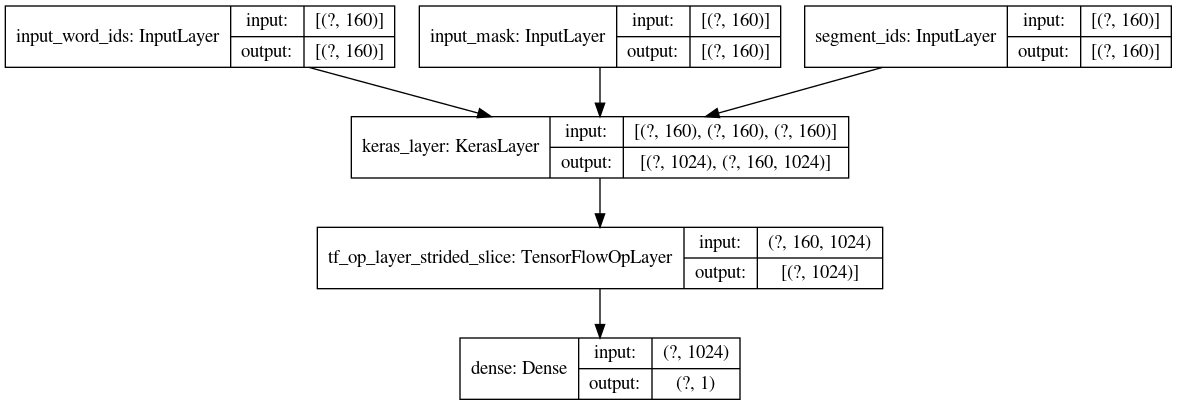

In [10]:
tf.keras.utils.plot_model(model, 'my_model.png', show_shapes=True)

In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_weights_only=True)

In [12]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16,
    verbose = 1,
    callbacks=[checkpoint]
)

In [15]:
#model.load_weights('/kaggle/input/model-1/model.h5')

In [22]:
test_pred = model.predict(test_input)

In [26]:
submission['target'] = test_pred.round().astype(int)
    
submission.to_csv("submission3000.csv", index=False)